In [1]:
#export
from fastai.vision.all import *
import gradio as gr
import timm

In [2]:
timm.list_models('beit*')

['beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512']

In [3]:
path = untar_data(URLs.PETS)/'images'

dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=RegexLabeller(pat = r'^([^/]+)_\d+'),
    item_tfms=Resize(224, method='squish'), bs=32)

In [4]:
learn = vision_learner(dls, 'beit_base_patch16_224_in22k', metrics=error_rate)

/home/jhoward/mambaforge/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755888534/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
learn.fine_tune(1)

RuntimeError: CUDA out of memory. Tried to allocate 74.00 MiB (GPU 0; 4.00 GiB total capacity; 3.31 GiB already allocated; 0 bytes free; 3.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [5]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

In [6]:
learn.fine_tune(1)

In [15]:
learn.export('model.lrn')

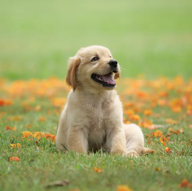

In [54]:
im = PILImage.create('dog.jpg')
im.thumbnail((192,192))
im

In [17]:
#export
learn = load_learner('model.pkl')

In [139]:
learn.predict(im)

('False', TensorBase(0), TensorBase([9.9995e-01, 4.8196e-05]))

In [125]:
#export
categories = ('Dog', 'Cat')

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

In [140]:
classify_image(im)

{'Dog': 0.9999518394470215, 'Cat': 4.8195579438470304e-05}

In [143]:
#export
image = gr.inputs.Image(shape=(192, 192))
label = gr.outputs.Label()
examples = ['dog.jpg', 'cat.jpg', 'dunno.jpg']

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch()

Running on local URL:  http://127.0.0.1:7866/

To create a public link, set `share=True` in `launch()`.


(<fastapi.applications.FastAPI at 0x7f80be4cccd0>,
 'http://127.0.0.1:7866/',
 None)

In [8]:
import requests,base64
from PIL import Image
from io import BytesIO

In [80]:
def data_url(filename, size=(192,192)):
    image = PILImage.create(filename)
    image.thumbnail(size)
    buff = BytesIO()
    image.save(buff, format="JPEG")
    prefix = f'data:image/{Path(filename).suffix[1:]};base64,'
    return prefix + base64.b64encode(buff.getvalue()).decode('utf-8')

In [91]:
data = {"data": [data_url('cat.jpg')]}
res = requests.post(url='https://hf.space/embed/jph00/testing/+/api/predict/', json=data).json()
res

{'data': [{'label': 'Cat',
   'confidences': [{'label': 'Cat', 'confidence': 1.0},
    {'label': 'Dog', 'confidence': 3.827755170118796e-13}]}],
 'flag_index': None,
 'updated_state': None,
 'durations': [1.636493444442749],
 'avg_durations': [1.2002585530281067]}